# MDI 720 : Statistiques
## Lasso
### *Joseph Salmon*

This notebook reproduces the pictures for the course "Lasso_fr"

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # for plots
from matplotlib import rc
from os import mkdir, path
from functools import partial  # functions that act on or return other function
from functions_Lasso import LSLassoCV, PredictionError, \
    ScenarioEquiCor, ridge_path, refitting, my_nonzeros
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Lasso, \
    lasso_path
from sklearn.linear_model import enet_path
from matplotlib.patches import Polygon, Circle
from prox_collection import l22_objective, l1_objective, l0_objective, \
    scad_objective, mcp_objective, log_objective, sqrt_objective, \
    enet_objective, l22_pen, l1_pen, l0_pen, scad_pen,\
    mcp_pen, log_pen, sqrt_pen, enet_pen

np.random.seed(seed=666)

%matplotlib notebook

In [2]:
dirname = "../prebuiltimages/"
if not path.exists(dirname):
    mkdir(dirname)

imageformat = '.pdf'
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
plt.close("all")

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()


###############################################################################
# display function:

saving = False


def my_saving_display(fig, dirname, filename, imageformat, saving=False):
    """"Saving with personal function."""
    filename = filename.replace('.', 'pt')  # remove "." to avoid floats issues
    if saving is True:
        dirname + filename + imageformat
        image_name = dirname + filename + imageformat
        fig.savefig(image_name)

<IPython.core.display.Javascript object>


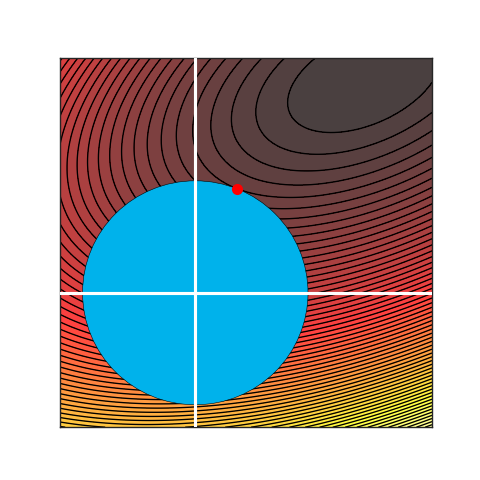

<IPython.core.display.Javascript object>


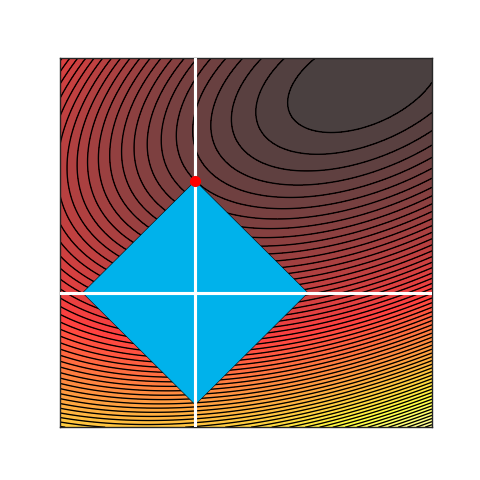

In [3]:

###############################################################################
# Motivation for Lasso: projection on balls / squares:

def funct_quadratic(X, Y):
    """ quadratic function to be displayed"""
    X1 = 1.5
    X2 = 1.9
    theta = -np.pi / 3 - 0.1
    c = np.cos(theta)
    s = np.sin(theta)
    elong = 0.3
    return ((c * (X - X1) + s * (Y - X2)) ** 2 +
            elong * (-s * (X - X1) + c * (Y - X2)) ** 2)

spacing = funct_quadratic(0, 1) / 6 * np.arange(70)   # for level lines
Y, X = np.mgrid[-1.2:2.1:100j, -1.2:2.1:100j]


# Projection over a ball
fig3 = plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
plt.axhline(0, color='white', zorder=4)
plt.axvline(0, color='white', zorder=4)
pt = 0.37
plt.plot(pt, np.sqrt(1 - pt ** 2), '.', markersize=20,
         color=(1, 0., 0.), zorder=5)
plt.contour(X, Y, funct_quadratic(X, Y), spacing, colors='k', linewidths=1.2)
plt.contourf(X, Y, funct_quadratic(X, Y), spacing, alpha=.75, cmap=plt.cm.hot)
circle1 = Circle((0, 0), 1, color=(0, 178. / 255, 236. / 256), ec='k',
                 alpha=1, zorder=2)
fig3.gca().add_artist(circle1)
plt.show()
my_saving_display(fig3, dirname, "l2_ball_projection", imageformat)


# Projection over a diamond
fig3 = plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
plt.axhline(0, color='white', zorder=4)
plt.axvline(0, color='white', zorder=4)
pt = 0
plt.plot(pt, np.sqrt(1 - pt ** 2), '.', markersize=20, color=(1, 0., 0.),
         zorder=5)
plt.contourf(X, Y, funct_quadratic(X, Y), spacing, alpha=.75, cmap=plt.cm.hot)
plt.contour(X, Y, funct_quadratic(X, Y), spacing, colors='k', linewidths=1.2)
polygon = Polygon([[1, 0], [0, 1], [-1, 0], [0, -1]],
                  color=(0, 178. / 255, 236. / 256), ec='k', alpha=1, zorder=2)
fig3.gca().add_artist(polygon)
plt.show()
my_saving_display(fig3, dirname, "l1_ball_projection", imageformat)


<IPython.core.display.Javascript object>


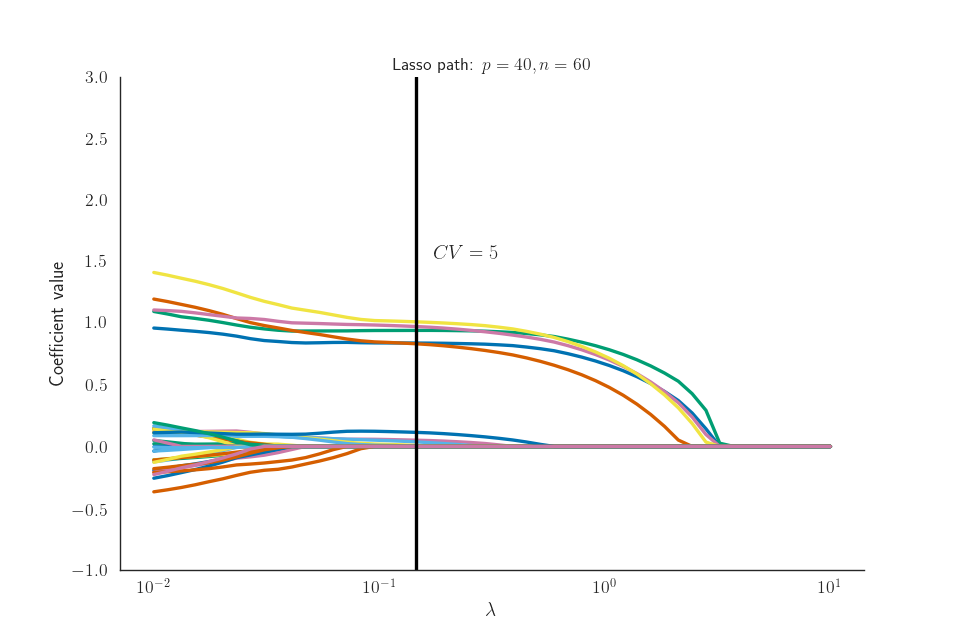

Sparsity level for LassoCV: 10


In [4]:
###############################################################################
# Lasso

n_features = 40
n_samples = 60

y, theta_true, X = ScenarioEquiCor(n_samples=n_samples,
                                   n_features=n_features,
                                   sig_noise=1,
                                   rho=0.5, s=5, normalize=True)

alpha_max = 1e1
eps = 1e-3
n_alphas = 50  # grid size
alphas = np.logspace(np.log10(alpha_max), np.log10(alpha_max * eps),
                     num=n_alphas)
_, theta_lasso, _ = lasso_path(X, y, alphas=alphas, fit_intercept=False,
                               return_models=False)

# plot lasso path
fig1 = plt.figure(figsize=(12, 8))
plt.title("Lasso path: " + r"$p={0}, n={1} $".format(n_features,
          n_samples), fontsize=16)
ax1 = fig1.add_subplot(111)
ax1.plot(alphas, np.transpose(theta_lasso), linewidth=3)
ax1.set_xscale('log')
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("Coefficient value")
ax1.set_ylim([-1, 3])
sns.despine()
plt.show()
my_saving_display(fig1, dirname, "Lasso_path", imageformat)

# nb of folds for CV
CV = 5
clf = LassoCV(alphas=alphas, fit_intercept=False, normalize=False, cv=CV)
clf.fit(X, y)

coef_lasso = clf.coef_
alpha_CV = clf.alpha_
index_lasso = np.where(alphas == alpha_CV)[0][0]

# plot lasso path with CV choice
ax1.axvline(clf.alpha_, color='K', linestyle='-', linewidth=3)
plt.annotate(r"$CV={0}$".format(CV).format(CV), xy=(1.2 * alpha_CV, +0.8),
             xycoords='data', xytext=(0, 80), textcoords='offset points',
             fontsize=18)
my_saving_display(fig1, dirname, "Lasso_path_CV", imageformat)


# Support and support size:
support_lasso_cv = my_nonzeros(coef_lasso)
print('Sparsity level for LassoCV: ' + str(support_lasso_cv.shape[0]))



<IPython.core.display.Javascript object>


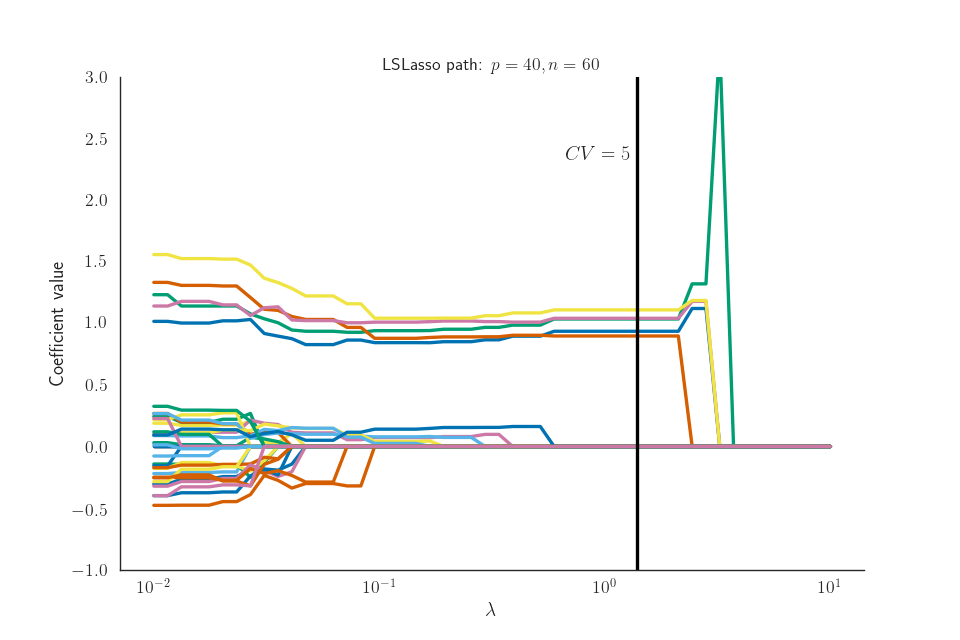

Sparsity level for LSLassoCV: 5


In [5]:
###############################################################################
# LSLasso: refitting on the support

theta_lslasso, _, _ = refitting(theta_lasso, X, y)

fig1 = plt.figure(figsize=(12, 8))
plt.title("LSLasso path: " + r"$p={0}, n={1} $".format(n_features,
          n_samples), fontsize=16)
ax1 = fig1.add_subplot(111)
ax1.plot(alphas, np.transpose(theta_lslasso), linewidth=3)
ax1.set_xscale('log')
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("Coefficient value")
ax1.set_ylim([-1, 3])
sns.despine()
plt.show()
my_saving_display(fig1, dirname, "LSLasso_path", imageformat)


# LSLasso: refitting the on the support, tuning by CV
coef_lslasso, index_lslasso = LSLassoCV(X, y, alphas, cv=CV, max_iter=10000,
                                        tol=1e-7, fit_intercept=False)

alpha_LSCV = alphas[index_lslasso]

index_lslasso = index_lslasso[0]
ax1.axvline(alpha_LSCV, color='K', linestyle='-', linewidth=3)
plt.annotate(r"$CV={0}$".format(CV), xy=(1.2 * alphas[index_lslasso], 1.6),
             xycoords='data', xytext=(-80, 80), textcoords='offset points',
             fontsize=18)
plt.show()
my_saving_display(fig1, dirname, "LSLasso_path_CV", imageformat)


# Support and support size:
support_lslasso_cv = my_nonzeros(coef_lslasso)
print('Sparsity level for LSLassoCV: ' + str(support_lslasso_cv.shape[0]))

<IPython.core.display.Javascript object>


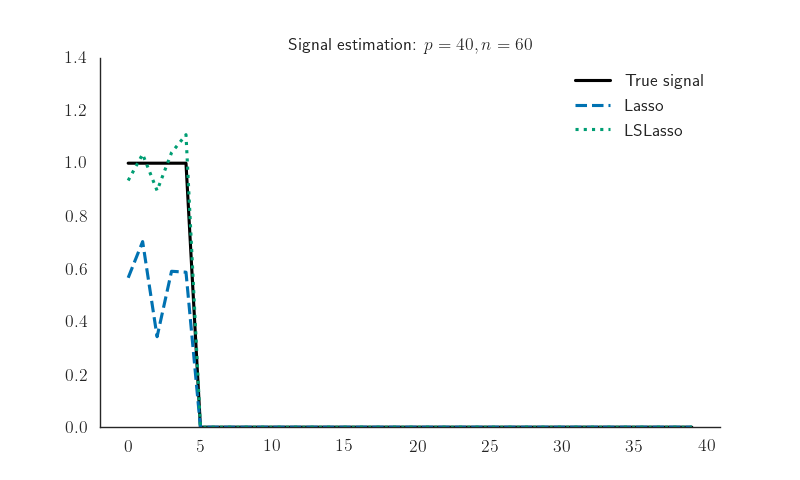

In [6]:
###############################################################################
# signal with Lasso and LSLasso: illustrating the Lasso bias

fig5 = plt.figure(figsize=(10, 6))
ax5 = fig5.add_subplot(111)
ax5.plot(theta_true, 'k', label="True signal")
ax5.set_ylim([0, 1.4])
ax5.plot(theta_lasso[:, index_lslasso], '--', label="Lasso")
plt.title(" Signal estimation: " + r"$p={0}, n={1} $".format(n_features,
          n_samples), fontsize=16)
plt.legend()
sns.despine()
plt.show()
my_saving_display(fig5, dirname, "Estimation_signal", imageformat)

ax5.plot(theta_lslasso[:, index_lslasso], ':', label="LSLasso")
plt.legend()
plt.show()
my_saving_display(fig5, dirname, "Estimation_signal_withLS", imageformat)


In [7]:
###############################################################################
# Elastic Net

def enet_plot(l1_ratio):
    """Function plotting enet_path for some tuning parameter."""
    _, theta_enet, _ = enet_path(X, y, alphas=alphas, fit_intercept=False,
                                 l1_ratio=l1_ratio, return_models=False)
    fig1 = plt.figure(figsize=(12, 8))
    plt.title("Enet path: " + r"$p={0}, n={1} $".format(n_features,
              n_samples), fontsize=16)
    ax1 = fig1.add_subplot(111)
    ax1.plot(alphas, np.transpose(theta_enet), linewidth=3)
    ax1.set_xscale('log')
    ax1.set_xlabel(r"$\lambda$")
    ax1.set_ylabel("Coefficient value")
    ax1.set_ylim([-1, 2])
    sns.despine()
    plt.show()
    filename = "Enet_path" + str(l1_ratio)
    filename = filename.replace(".", "")
    my_saving_display(fig1, dirname, filename, imageformat)
    return theta_enet

<IPython.core.display.Javascript object>


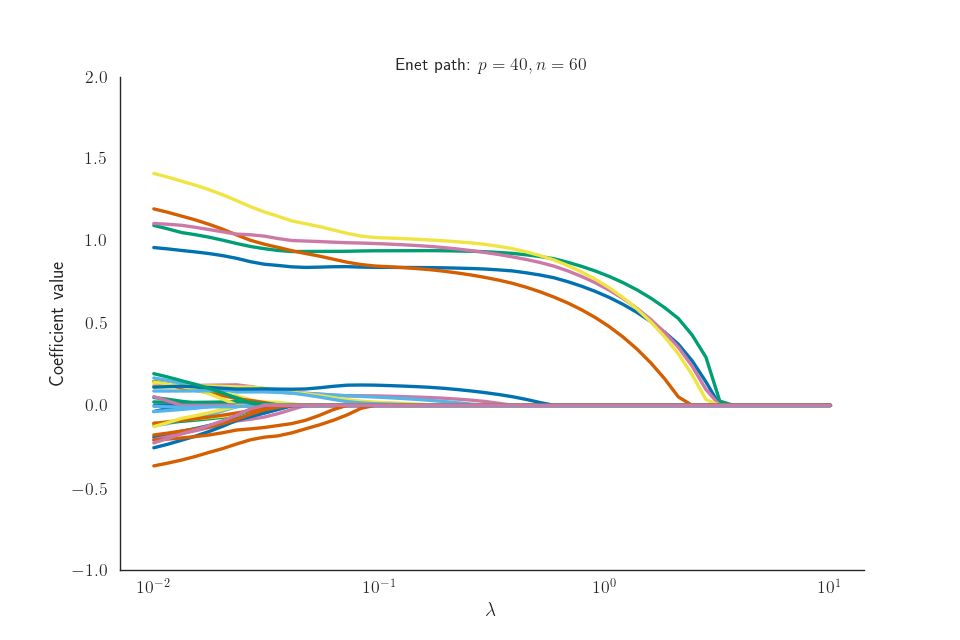

In [8]:
theta_enet1 = enet_plot(1.00)


<IPython.core.display.Javascript object>


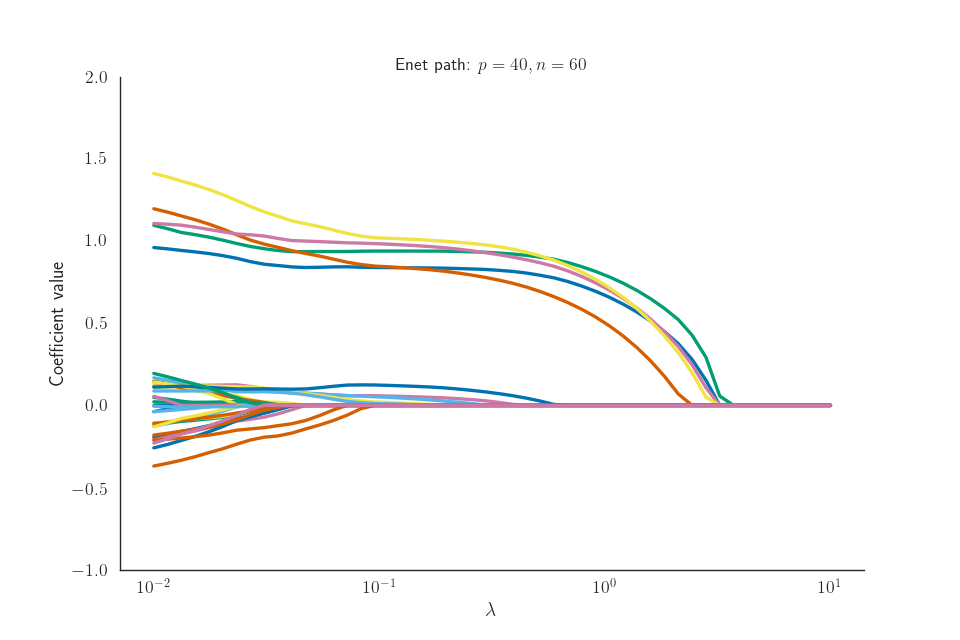

In [9]:
theta_enet099 = enet_plot(0.99)


<IPython.core.display.Javascript object>


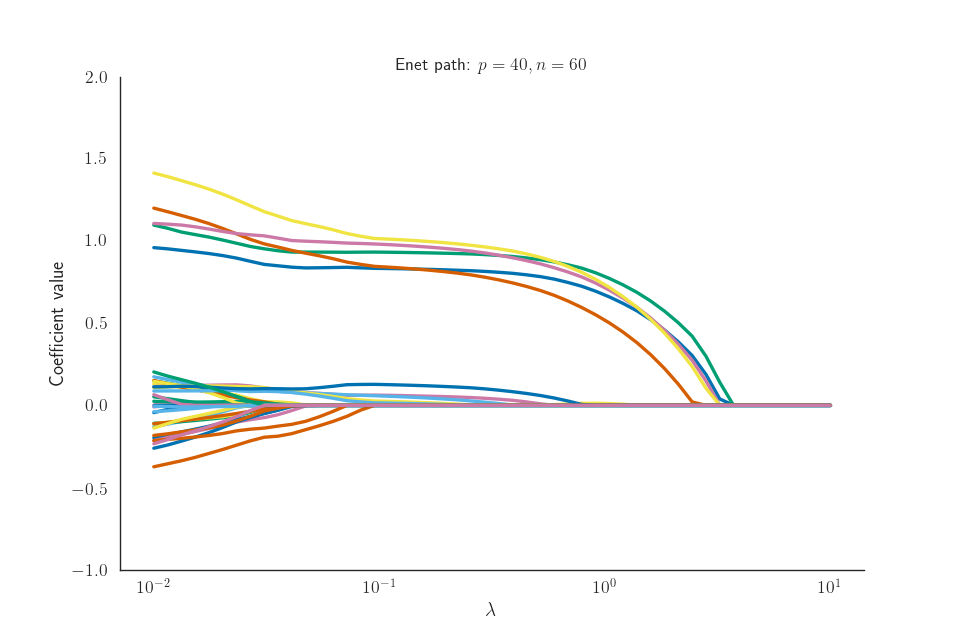

In [10]:
theta_enet095 = enet_plot(0.95)

<IPython.core.display.Javascript object>


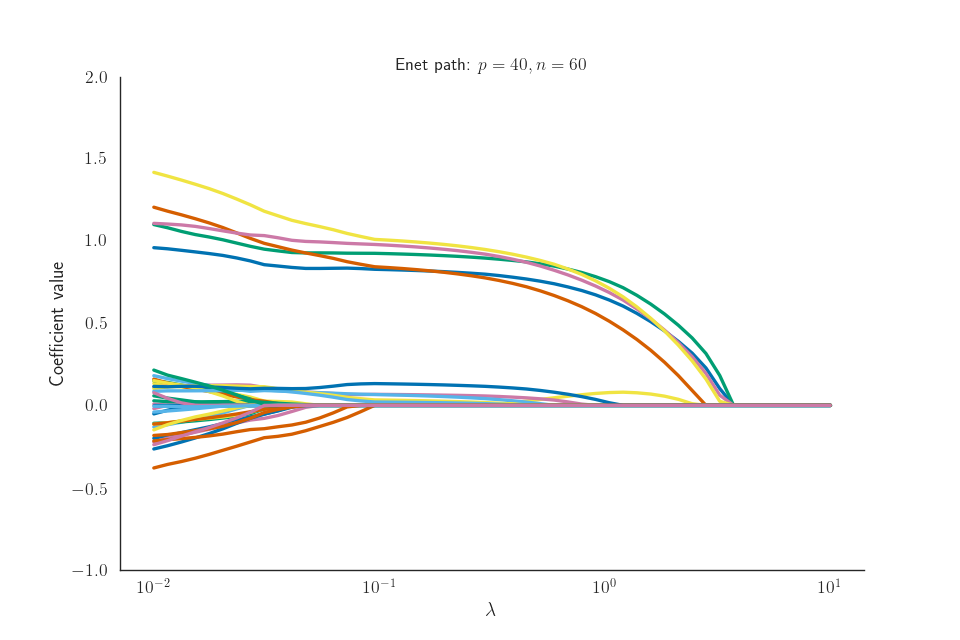

In [11]:
theta_enet090 = enet_plot(0.90)

<IPython.core.display.Javascript object>


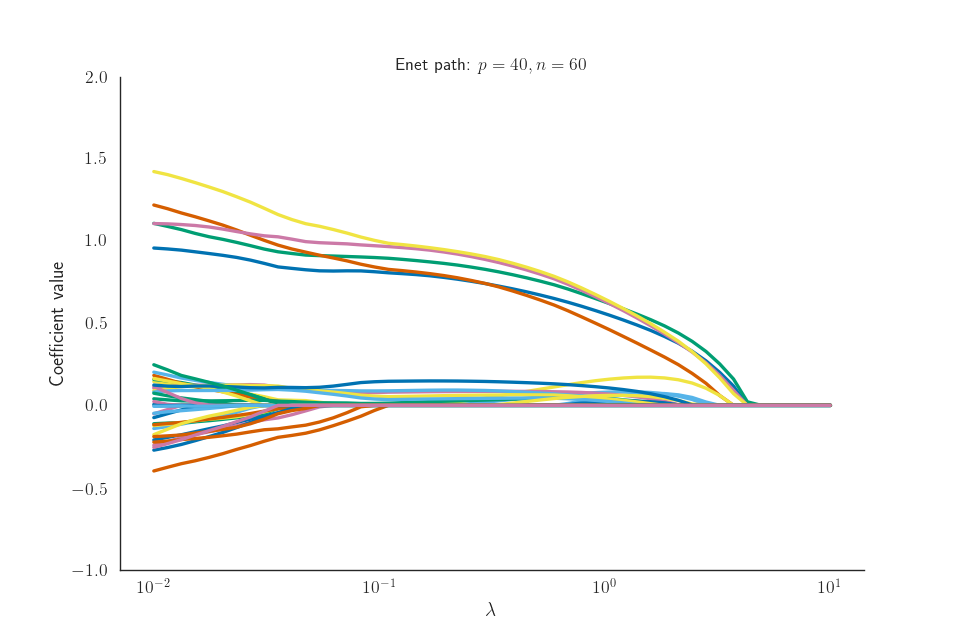

In [12]:
theta_enet075 = enet_plot(0.75)

<IPython.core.display.Javascript object>


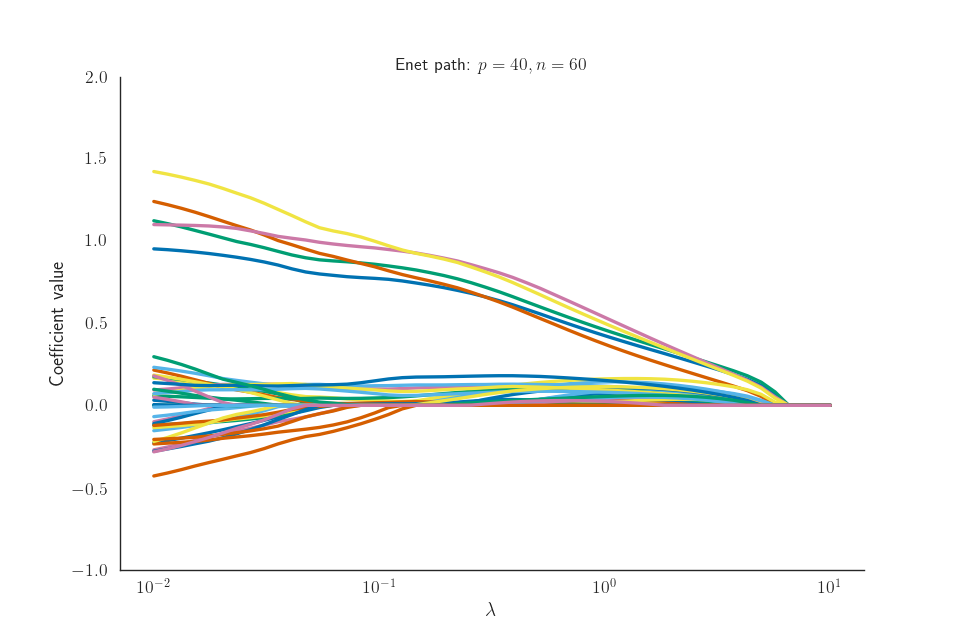

In [13]:
theta_enet05 = enet_plot(0.50)

<IPython.core.display.Javascript object>


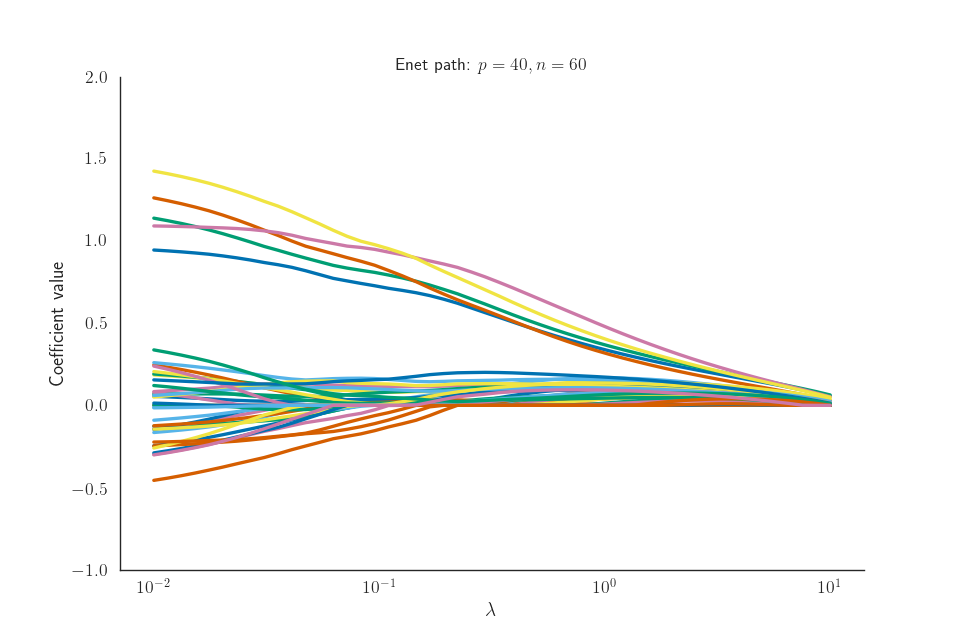

In [14]:
theta_enet025 = enet_plot(0.25)

<IPython.core.display.Javascript object>


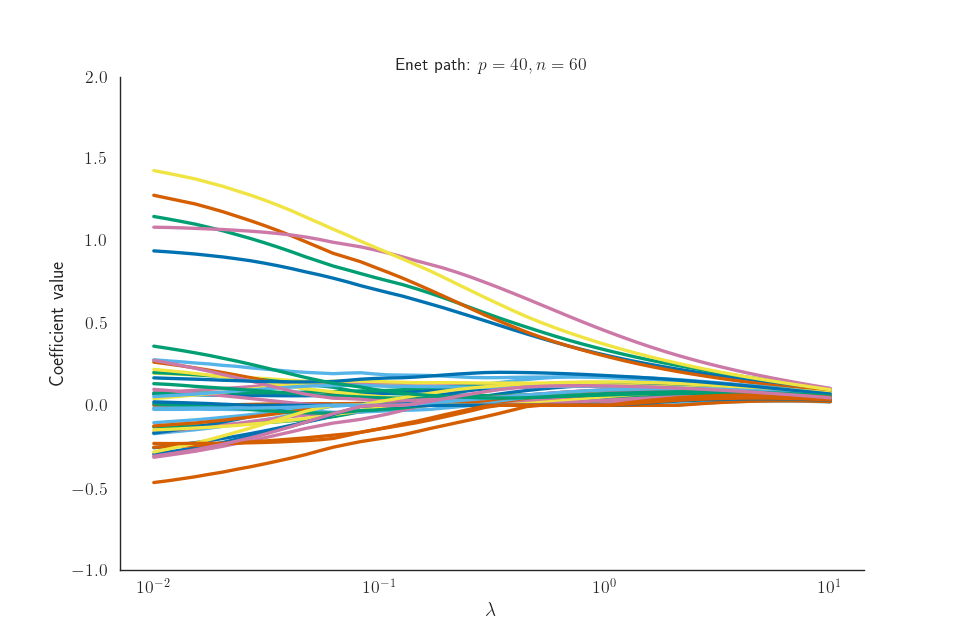

In [15]:
theta_enet010 = enet_plot(0.10)

<IPython.core.display.Javascript object>


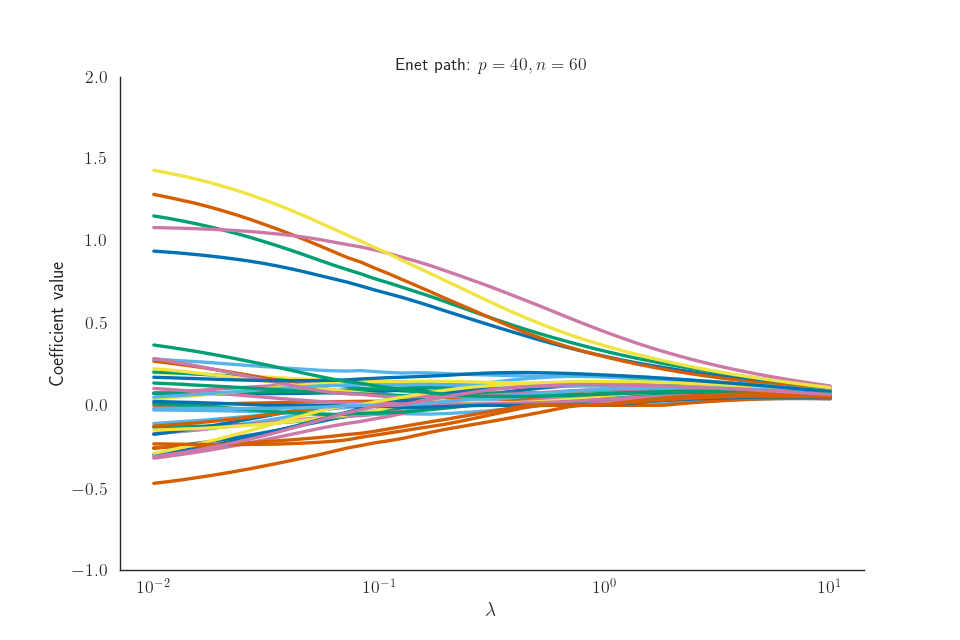

In [16]:
theta_enet005 = enet_plot(0.05)

<IPython.core.display.Javascript object>


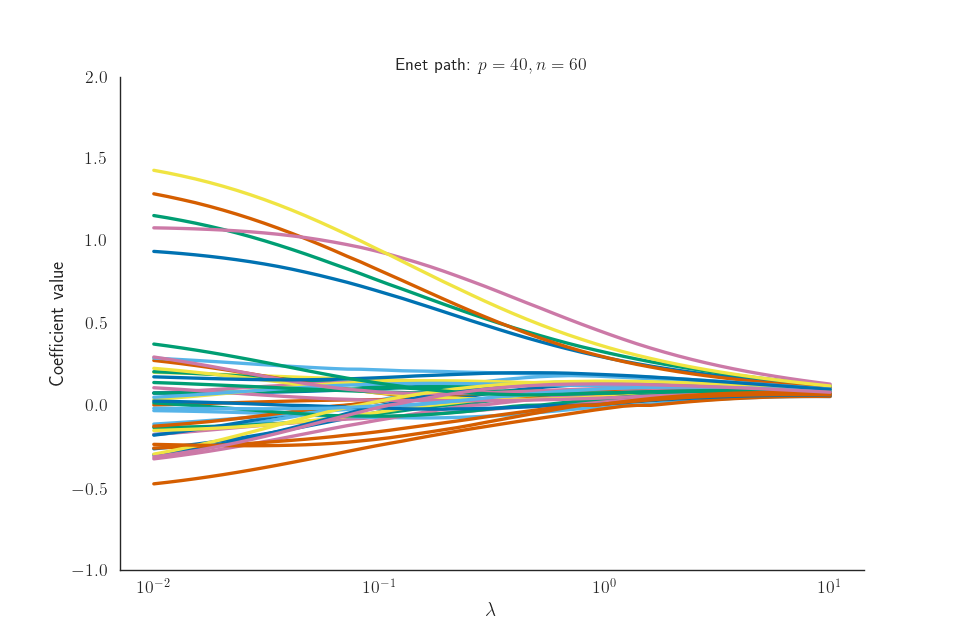

In [17]:
theta_enet001 = enet_plot(0.01)

/home/jo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/jo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


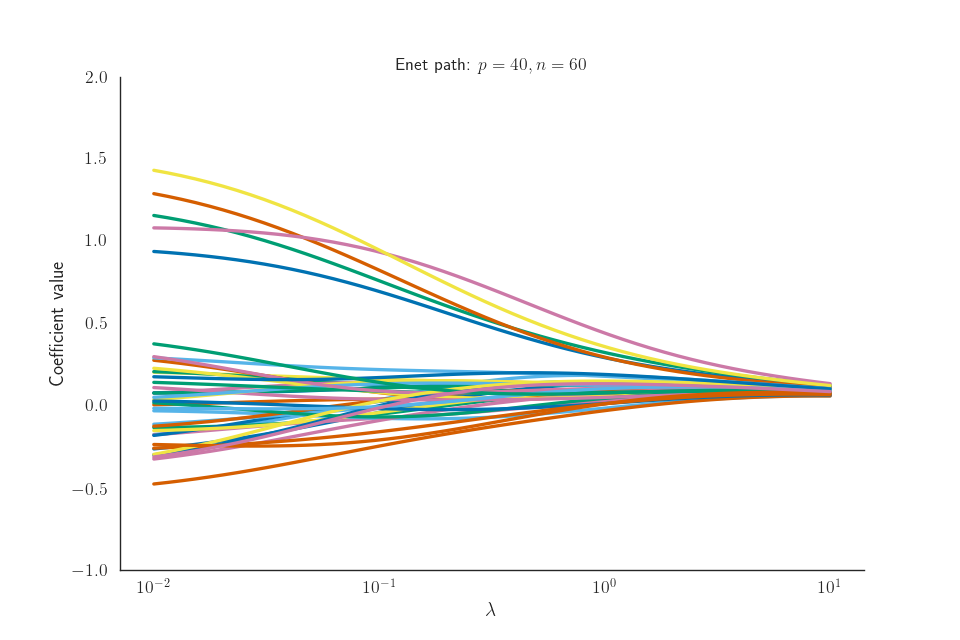

In [18]:
theta_enet0 = enet_plot(0.00)

<IPython.core.display.Javascript object>


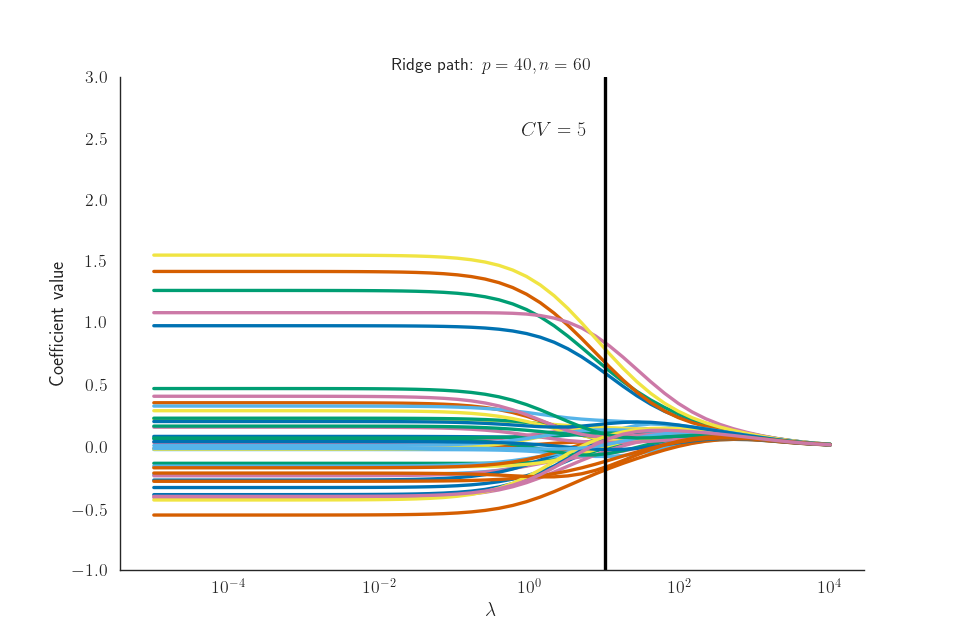

In [19]:
###############################################################################
# Ridge

alpha_max = 1e4
eps = 1e-9
alphas_ridge = np.logspace(np.log10(alpha_max), np.log10(alpha_max * eps),
                           num=n_alphas)
theta_ridge = ridge_path(X, y, alphas_ridge)
clf_ridge = RidgeCV(alphas=alphas, fit_intercept=False, normalize=False, cv=CV)
clf_ridge.fit(X, y)

fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(111)
plt.title("Ridge path: " + r"$p={0}, n={1} $".format(n_features,
          n_samples), fontsize=16)
ax1.plot(alphas_ridge, np.transpose(theta_ridge), linewidth=3)
ax1.set_xscale('log')
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("Coefficient value")
ax1.set_ylim([-1, 3])
sns.despine()
plt.show()
my_saving_display(fig1, dirname, "Ridge_path", imageformat)

# plot ridge path with CV choice
ax1.axvline(clf_ridge.alpha_, color='K', linestyle='-', linewidth=3)
plt.annotate(r"$CV={0}$".format(CV), xy=(1.2 * clf_ridge.alpha_, 1.8),
             xycoords='data', xytext=(-80, 80), textcoords='offset points',
             fontsize=18)
plt.show()
my_saving_display(fig1, dirname, "Ridge_path_CV", imageformat)


<IPython.core.display.Javascript object>


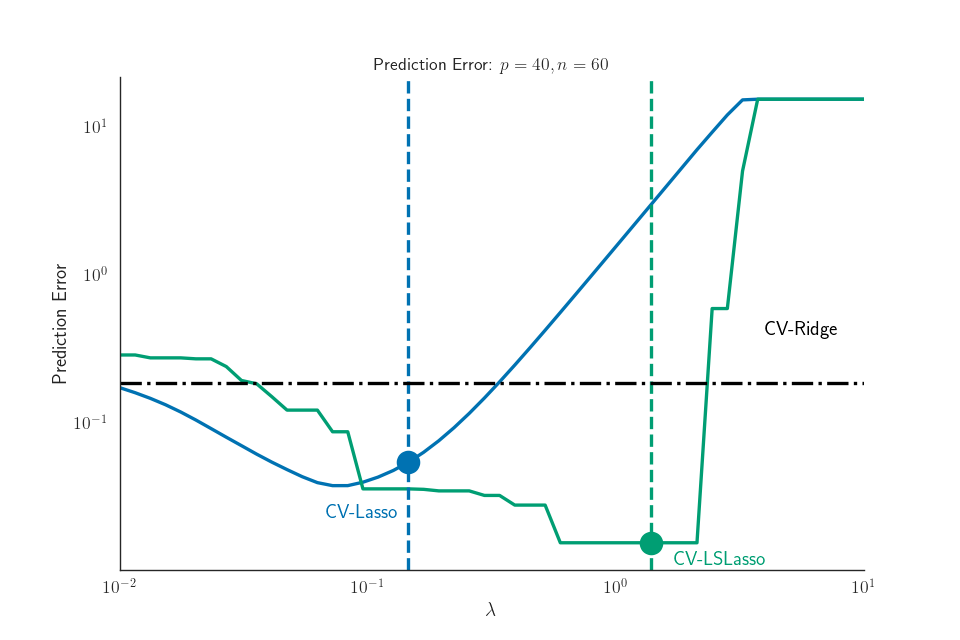

In [20]:
###############################################################################
# plot prediction error

fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(111)
plt.title("Prediction Error: " + r"$p={0}, n={1} $".format(n_features,
          n_samples), fontsize=16)
ax1.plot(alphas, PredictionError(X, theta_lasso, theta_true), linewidth=3,
         label="Lasso")
ax1.plot(alphas, PredictionError(X, theta_lslasso, theta_true), linewidth=3,
         label="LSLasso")

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("Prediction Error")

LassoCVMSE = PredictionError(X, theta_lasso[:, index_lasso], theta_true)
LSLassoCVMSE = PredictionError(X, theta_lslasso[:, index_lslasso], theta_true)

current_palette = sns.color_palette()

ax1.scatter(alpha_CV, LassoCVMSE, color=current_palette[0], linewidth=10)
ax1.scatter(alpha_LSCV, LSLassoCVMSE, color=current_palette[1], linewidth=10)

ax1.axvline(alpha_CV, linestyle='--', color=current_palette[0], linewidth=3)
ax1.axvline(alpha_LSCV, linestyle='--', color=current_palette[1], linewidth=3)

plt.annotate('CV-Lasso', xy=(alpha_CV, LassoCVMSE), xycoords='data',
             color=current_palette[0], xytext=(-74, -50),
             textcoords='offset points', fontsize=18)
plt.annotate('CV-LSLasso', xy=(alpha_LSCV, LSLassoCVMSE), xycoords='data',
             color=current_palette[1], xytext=(20, -20),
             textcoords='offset points', fontsize=18)
plt.annotate('CV-Ridge', xy=(alphas[0] - 6, 0.1), xycoords='data',
             color='K', xytext=(0, 80), textcoords='offset points',
             fontsize=18)

ax1.set_xlim(alphas[-1], alphas[0])
ax1.axhline(PredictionError(X, clf_ridge.coef_, theta_true), linestyle='-.',
            color='K', linewidth=3)
sns.despine()
plt.show()
my_saving_display(fig1, dirname, "various_path_prediction_error", imageformat)

In [21]:
###############################################################################
# Adaptive Lasso:

# index_choice = index_lasso  # same as the one obtained by LassoCV
index_choice = index_lslasso  # same as the one obtained by LSLassoCV
alpha = alphas[index_choice]
# index_choice = 24
# alpha = alphas[index_choice]


def sqr_abs(w):
    """ square root of absolute value: adapative lasso penalty"""
    return np.sqrt(np.abs(w))


def sqr_abs_prime(w):
    """ square root of absolute value: adapative lasso penalty"""
    return 1. / (2. * np.sqrt(np.abs(w)) + np.finfo(float).eps)


n_samples, n_features = X.shape


def primal_obj(w):
    """ objective function to optimize in adapative lasso"""
    return 1. / (2 * n_samples) * np.sum((y - np.dot(X, w)) ** 2) \
        + alpha * np.sum(sqr_abs(w))

weights = np.ones(n_features)
n_lasso_iterations = 5

print("Prd. risk Lasso  :" +\
    str(PredictionError(X, theta_lasso[:, index_choice], theta_true)))
print("Prd. risk LSLasso:" +\
    str(PredictionError(X, theta_lslasso[:, index_choice], theta_true)))


for k in range(n_lasso_iterations):
    X_w = X / weights[np.newaxis, :]
    clf_adapt = Lasso(alpha=alpha, fit_intercept=False)
    clf_adapt.fit(X_w, y)
    coef_ = clf_adapt.coef_ / weights
    weights = sqr_abs_prime(coef_)
    print("Objective: " + str(primal_obj(coef_)) + " Prediction Risk: " + \
        str(PredictionError(X, coef_, theta_true)))
    # Objective should decrease with k, not necessarily Prediction Risk
np.sum(clf_adapt.coef_ != 0.0)
# print np.mean((clf_adapt.coef_ != 0.0) == (theta_true != 0.0))

Prd. risk Lasso  :3.0691559075
Prd. risk LSLasso:0.0158364434605
Objective: 7.10088763018 Prediction Risk: 3.06925639871
Objective: 6.59266423489 Prediction Risk: 1.71545801662
Objective: 6.36554760306 Prediction Risk: 1.46641140906
Objective: 6.35526798332 Prediction Risk: 1.48479946763
Objective: 6.32528578994 Prediction Risk: 1.61244789956


4

In [22]:
def plot_pen(x, threshold, pen, image_name, title):
    """ function to plot and save pen functions"""
    xx = pen(x, threshold)
    fig0 = plt.figure(figsize=(6, 6))
    ax1 = plt.subplot(111)
    ax1.plot(x, xx, label=label)
    ax1.get_yaxis().set_ticks([])
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylim(-0.1, np.max(xx) * 1.05)
    ax1.set_xlim(-10, 10)
    plt.title(title)
    plt.show()
    my_saving_display(fig0, dirname, image_name + "pen", imageformat)
    return

<IPython.core.display.Javascript object>


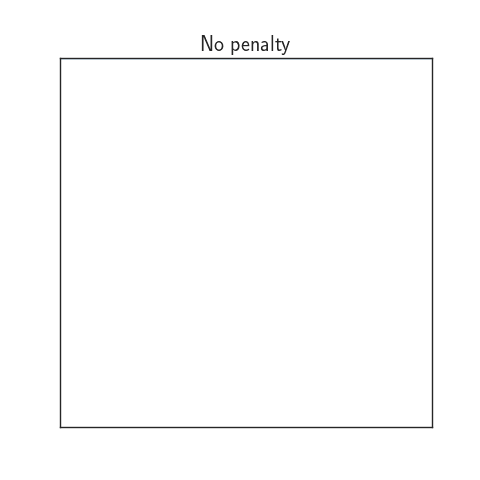

In [23]:
x = np.arange(-10, 10, step=0.01)

# No penalty
image_name = "no_pen_orth_1d"
label = r"$\eta_{0}$"
pen_l1 = l1_pen
plot_pen(x, 0, pen_l1, image_name,'No penalty')

<IPython.core.display.Javascript object>


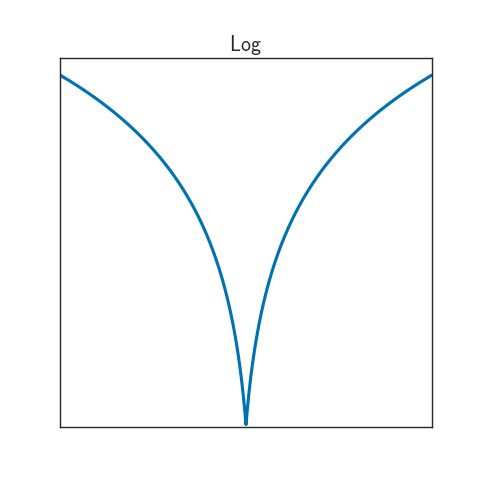

In [24]:
# log
threshold = 4.5
epsilon = .5
label = r"$\eta_{\rm {log},\lambda,\gamma}$"
image_name = "log_orth_1d"
pen_log = partial(log_pen, epsilon=epsilon)
plot_pen(x, threshold, pen_log, image_name,'Log')

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


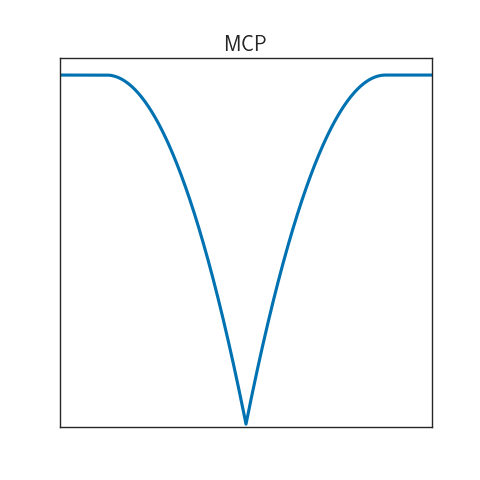

In [25]:

# mcp prox
threshold = 3
gamma = 2.5
label = r"$\eta_{\rm {MCP},\lambda,\gamma}$"
image_name = "mcp_orth_1d"
pen_mcp = partial(mcp_pen, gamma=gamma)
plot_pen(x, threshold, pen_mcp, image_name,'MCP')


/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


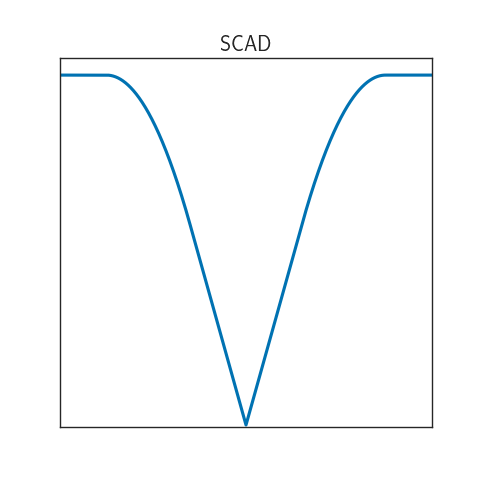

In [26]:
# SCAD
label = r"$\eta_{\rm {SCAD},\lambda,\gamma}$"
image_name = "scad_orth_1d"
pen_scad = partial(scad_pen, gamma=gamma)
plot_pen(x, threshold, pen_scad, image_name,'SCAD')


/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


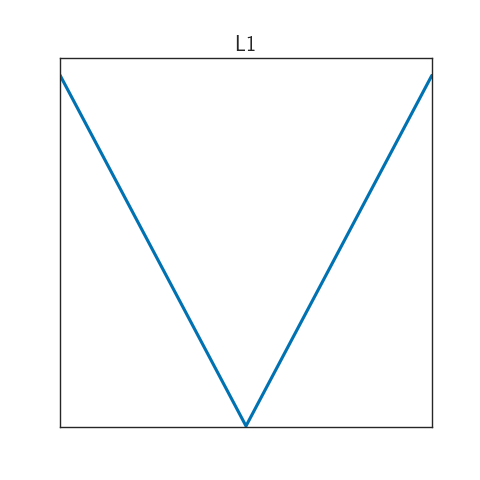

In [27]:
# L1
image_name = "l1_orth_1d"
label = r"$\eta_{\rm {ST},\lambda}$"
pen_l1 = l1_pen
plot_pen(x, threshold, pen_l1, image_name,'L1')


/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


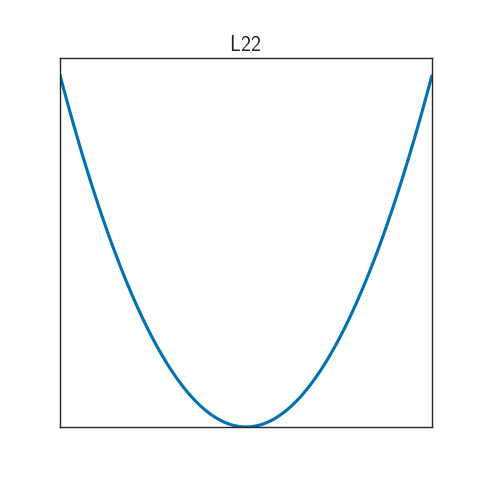

In [28]:
# L22 
label = r"$\eta_{\rm {Ridge},\lambda}$"
image_name = "l22_orth_1d"
pen_l22 = l22_pen
plot_pen(x, threshold, pen_l22, image_name,'L22')


/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


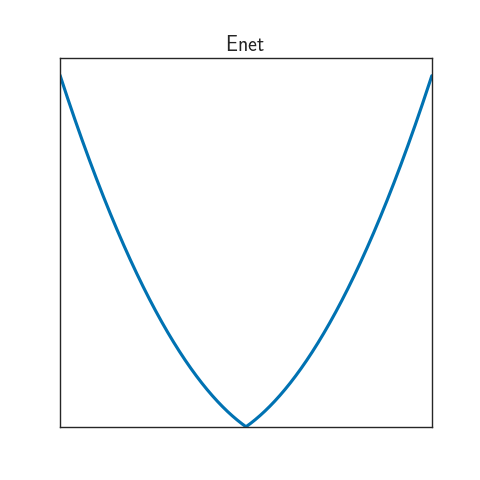

In [29]:
# Enet
beta = 1
label = r"$\eta_{\rm {Enet},\lambda,\gamma}$"
image_name = "enet_orth_1d"
pen_enet = partial(enet_pen, beta=beta)
plot_pen(x, threshold, pen_enet, image_name,'Enet')


/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


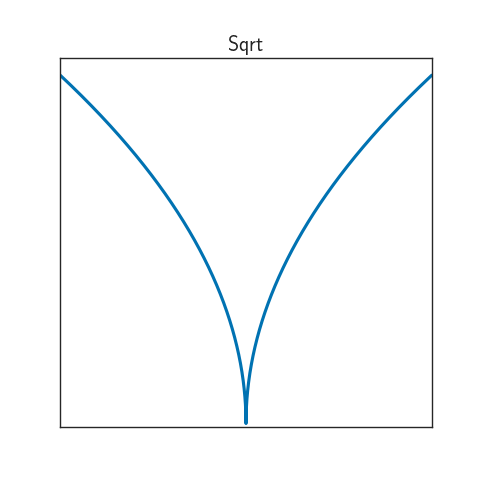

In [30]:
# Sqrt
label = r"$\eta_{\rm {sqrt},\lambda}$"
image_name = "sqrt_orth_1d"
pen_sqrt = sqrt_pen
plot_pen(x, threshold, pen_sqrt, image_name,'Sqrt')

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


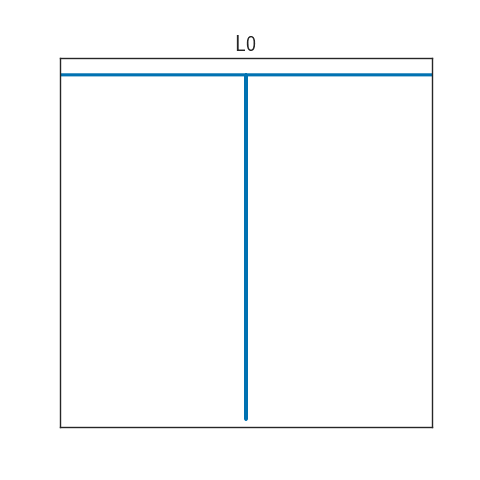

In [31]:
# L0
threshold = 4.5
label = r"$\eta_{\rm {HT},\lambda}$"
image_name = "l0_orth_1d"
pen_l0 = l0_pen
plot_pen(x, threshold, pen_l0, image_name,'L0')

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


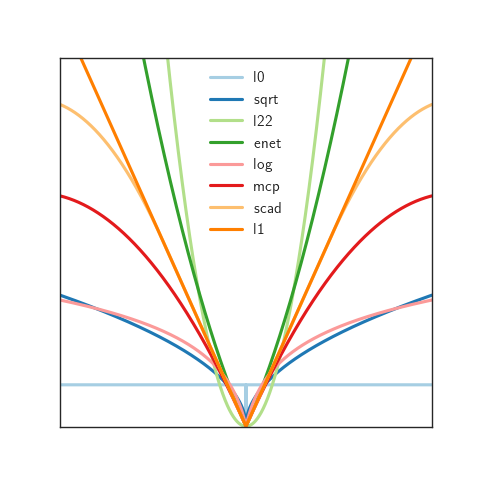

In [32]:
###############################################################################
# ploting penalty functions altogether
sns.set_palette("Paired", 10)
# sns.set_palette("colorblind")

fig0 = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)

ax1.plot(x, pen_l0(x, threshold), label='l0')
ax1.plot(x, pen_sqrt(x, threshold), label='sqrt')
ax1.plot(x, pen_l22(x, threshold), label='l22')
ax1.plot(x, pen_enet(x, threshold), label='enet')
ax1.plot(x, pen_log(x, threshold), label='log')
ax1.plot(x, pen_mcp(x, threshold), label='mcp')
ax1.plot(x, pen_scad(x, threshold), label='scad')
ax1.plot(x, pen_l1(x, threshold), label='l1')

ax1.set_ylim(-0.1, 40)
ax1.set_xlim(-10, 10)
ax1.get_yaxis().set_ticks([])
ax1.get_xaxis().set_ticks([])
plt.legend(loc="upper center", fontsize=14)

plt.show()
my_saving_display(fig0, dirname, "penalties", imageformat, saving=saving)
